# Parameters

In [1]:
#PARAMETERS

# model
Nit = 16
Nep = 60
ONE_MODEL = True

# bootstrap
APPLY_BOOTS = False
NPULLS = 200
SAMPLE_SIZE_TRAIN=1_000_000
SAMPLE_SIZE_EVAL=500_000 # reduce size of evaluation data

In [2]:
# Variables: Label
# drop out all events with Energies outside the range
LOWER_LIMIT = 100
UPPER_LIMIT = 10**5#10**5

# Variables: NN
NUM_BINS = 10#10 # number of bins (energy classes), output_shape

# Imports and setting seed for PRNG

In [3]:
import numpy as np
np.random.seed(42)

In [4]:
# data management
import os
import pandas as pd

# data processing
import tensorflow as tf
from sklearn import utils
from sklearn.preprocessing import StandardScaler

# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Read in data

In [5]:
# Feature Selection
feature_list = ['SplineMPEDirectHitsICE.n_dir_doms', 
                        'VariousVariables.Cone_Angle',
                        'SplineMPECramerRaoParams.variance_theta',
                        'Borderness.Q_ratio_in_border',
                        'SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value',
                        'SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy',
                        'SplineMPEDirectHitsICB.n_late_doms',
                        'Dustyness.n_doms_in_dust',
                        'LineFitGeoSplit1Params.n_hits',
                        'SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness',
                        'SPEFit2GeoSplit1BayesianFitParams.logl',
                        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom']
# just read-in necessary columns
fields = feature_list + ['MCPrimary.energy']

# read in data
file_path = '/net/big-tank/POOL/users/lkardum/new_mc_binning.csv'
df_raw = pd.read_csv(file_path, skipinitialspace=True, usecols=fields)

In [6]:
# drop critical rows
df = df_raw.drop([ 1007671,  1426233,  2304853,  2715790,  3674355,  3741687, 4178063,  4969266,  5038333,  5334552,  5589516,  5863719,
 5978972,  7006367,  7281704,  7509650,  8380383,  8758113,9043798, 10280382, 11179530, 11184928, 11332586, 11797767,12253944], axis = 0)

# substitute NaNs with extreme Value
df.fillna(value =-100000, inplace = True)

# Discretize the target Neutrino Energy

In [7]:
# throw out extreme high and low energy neutrinos
df = df[(df['MCPrimary.energy']<UPPER_LIMIT) & (df['MCPrimary.energy']>LOWER_LIMIT)]
df

,SplineMPECramerRaoParams.variance_theta,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,MCPrimary.energy,SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness,SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value,SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom,LineFitGeoSplit1Params.n_hits,SplineMPEDirectHitsICB.n_late_doms,SplineMPEDirectHitsICE.n_dir_doms,Borderness.Q_ratio_in_border,SPEFit2GeoSplit1BayesianFitParams.logl,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle
0,0.000138,20601.845970,3086.645078,-0.147665,0.397322,41.003142,19.0,34.0,20.0,0.101743,158.569898,0.175000,0.022686
1,0.003101,9461.487291,193.041166,0.344174,0.545559,50.324590,39.0,13.0,11.0,0.011322,272.450606,0.057143,0.097690
2,0.000325,43222.679757,862.503704,0.281681,0.463602,39.265226,21.0,20.0,17.0,0.618235,73.385557,0.217391,0.049914
3,0.000066,9929.465219,288.757353,0.222210,0.397322,16.576652,12.0,16.0,13.0,0.041282,81.277756,0.875000,0.023061
4,0.001243,14979.867844,1838.155763,-0.233723,0.545559,11.832243,16.0,16.0,13.0,0.979636,90.623889,0.294118,0.222784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,0.002613,28988.905556,2680.561232,-0.204343,0.545559,24.473264,5.0,13.0,11.0,0.000000,56.708233,0.000000,0.149460
13336409,0.000112,13010.699980,1695.794619,0.567237,0.342283,41.072783,110.0,58.0,23.0,0.002037,302.582772,0.555556,0.134817
13336410,0.010503,15232.377792,579.684909,0.317987,0.545559,45.828011,13.0,19.0,17.0,0.274274,108.338541,0.125000,0.090354
13336411,0.004765,19444.610677,205.607328,0.341417,0.545559,42.645669,13.0,12.0,8.0,0.000000,107.530913,0.000000,0.128185


In [8]:
## log-scaled Binning
bins = np.logspace(np.log10(LOWER_LIMIT), np.log10(UPPER_LIMIT), NUM_BINS+1)
bins

array([   100.        ,    199.5262315 ,    398.10717055,    794.32823472,
         1584.89319246,   3162.27766017,   6309.5734448 ,  12589.25411794,
        25118.8643151 ,  50118.72336273, 100000.        ])

In [9]:
# new column with discretized energies

df['E_discr'] = pd.cut(df['MCPrimary.energy'], bins=bins, labels=range(len(bins)-1))
df['E_discr'].value_counts()

1    3265825
2    2971469
3    2110752
0    1939697
4    1327291
5     776316
6     435447
7     239490
8     128030
9      67777
Name: E_discr, dtype: int64

# Create target dataset

In [10]:
X = df[feature_list].to_numpy()
X.shape

(13262094, 12)

In [11]:
y = df['E_discr'].to_numpy()
y.shape

(13262094,)

In [12]:
# subsample size

def create_dataset(X, y, subset=0, validation_split=0.3, rng_seed=42):
    # X,y: numpy Array
    # subset: size of the subset (Int)
    # validation_split: (0, 1)
    rng = np.random.default_rng(rng_seed)
    perm = rng.permutation(len(X))

    if subset:
        perm = perm[0:subset]

    limit = int(len(perm)*(1-validation_split))

    X_train = X[perm[:limit]]
    X_eval = X[perm[limit:]]
    y_train = y[perm[:limit]]
    y_eval = y[perm[limit:]]

    return X_train, y_train, X_eval, y_eval

In [13]:
X_train, y_train, X_eval, y_eval = create_dataset(X, y, validation_split=0.1, subset=None)
print(X_train.shape, y_train.shape, X_eval.shape, y_eval.shape)

(11935884, 12) (11935884,) (1326210, 12) (1326210,)


In [14]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_eval = scaler.transform(X_eval)

In [15]:
# reduce size of train set
y_train = y_train[0:SAMPLE_SIZE_TRAIN]
X_train = X_train[0:SAMPLE_SIZE_TRAIN]
X_train.shape, y_train.shape

((1000000, 12), (1000000,))

In [16]:
# reduce size of test set
y_eval = y_eval[0:SAMPLE_SIZE_EVAL]
X_eval = X_eval[0:SAMPLE_SIZE_EVAL]
X_eval.shape, y_eval.shape

((500000, 12), (500000,))

# Build Neural Network

In [17]:
# neural network
def make_model(num_features, num_classes, learning_rate=0.0005):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(120, input_shape=num_features, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(240, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(12, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # compile the NN
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metric = tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)

    model.compile(optimizer=opt, loss=loss, metrics=[metric])

    return model

# Get model and data to this model

In [18]:
df_results = pd.read_csv(f'gridsearch_results_subsample/one_model_{ONE_MODEL}/results.csv')

In [19]:
def str_to_np(string):
    string = string.replace('  ', ' ')
    string = string.replace('[', '')
    string = string.replace(']', '')

    #print(string)
    
    return np.fromstring(string, sep=' ')

In [20]:
df_results['f_dsea_array'] = df_results['f_dsea'].apply(str_to_np)
df_results['f_true_array'] = df_results['f_true'].apply(str_to_np)
df_results['loss_array'] = df_results['loss'].apply(str_to_np)
df_results['acc_array'] = df_results['acc'].apply(str_to_np)
df_results['chi_array'] = df_results['chi2'].apply(str_to_np)

In [21]:
df_results.drop(['f_dsea', 'f_true', 'loss', 'acc'], axis=1, inplace=True)
df_results.head(10)

,epochs,iterations,chi2,f_dsea_array,f_true_array,loss_array,acc_array,chi_array
0,1,1,[0.10276137],"[0.17485247, 0.16353483, 0.14116895, 0.1109521...","[0.146518, 0.24642, 0.223364, 0.159558, 0.0997...",[0.04547212],[0.304269],[0.10276137]
1,1,3,[0.08855548 0.043207 0.02512434],"[0.20562752, 0.20059535, 0.16547301, 0.1333938...","[0.146518, 0.24642, 0.223364, 0.159558, 0.0997...","[0.04365039, 0.06623339, 0.08949959]","[0.306298, 0.342934, 0.353955]","[0.08855548, 0.043207, 0.02512434]"
2,1,6,[0.1206057 0.03103531 0.01575544 0.00849233 0...,"[0.16956389, 0.24355661, 0.18487913, 0.1618615...","[0.146518, 0.24642, 0.223364, 0.159558, 0.0997...","[0.04414035, 0.07427677, 0.10133233, 0.1201434...","[0.292227, 0.355084, 0.364745, 0.370096, 0.372...","[0.1206057, 0.03103531, 0.01575544, 0.00849233..."
3,1,8,[0.1132127 0.0375179 0.01588428 0.00872972 0...,"[0.14079675, 0.23795567, 0.21965109, 0.1584929...","[0.146518, 0.24642, 0.223364, 0.159558, 0.0997...","[0.04448928, 0.07049078, 0.0969658, 0.11738586...","[0.273832, 0.347813, 0.364916, 0.368917, 0.373...","[0.1132127, 0.0375179, 0.01588428, 0.00872972,..."
4,1,10,[0.0858719 0.03314998 0.01643179 0.00816311 0...,"[0.15235162, 0.25083579, 0.21554481, 0.1663698...","[0.146518, 0.24642, 0.223364, 0.159558, 0.0997...","[0.04394033, 0.07010446, 0.09716853, 0.1209333...","[0.303269, 0.351884, 0.362606, 0.370717, 0.373...","[0.0858719, 0.03314998, 0.01643179, 0.00816311..."
5,1,12,[0.09032509 0.03281725 0.01755708 0.01124829 0...,"[0.15678723, 0.24363708, 0.21401266, 0.1577272...","[0.146518, 0.24642, 0.223364, 0.159558, 0.0997...","[0.04414579, 0.06917133, 0.09178987, 0.1128334...","[0.309788, 0.353191, 0.362981, 0.367303, 0.374...","[0.09032509, 0.03281725, 0.01755708, 0.0112482..."
6,1,16,[0.09725191 0.03944891 0.02095061 0.01235569 0...,"[0.16604263, 0.25413332, 0.18456791, 0.1679099...","[0.146518, 0.24642, 0.223364, 0.159558, 0.0997...","[0.04422272, 0.07056283, 0.09567453, 0.1126826...","[0.300134, 0.343134, 0.356697, 0.364163, 0.366...","[0.09725191, 0.03944891, 0.02095061, 0.0123556..."
7,1,20,[0.09500284 0.03839299 0.02305771 0.01272223 0...,"[0.15473749, 0.22094123, 0.24846451, 0.1517288...","[0.146518, 0.24642, 0.223364, 0.159558, 0.0997...","[0.04346831, 0.0663019, 0.08886881, 0.10762373...","[0.294409, 0.350603, 0.357876, 0.36745, 0.3665...","[0.09500284, 0.03839299, 0.02305771, 0.0127222..."
8,5,1,[0.11044493 0.07713971 0.07614421 0.07593336 0...,"[0.16883216, 0.15974957, 0.13469065, 0.1214287...","[0.146518, 0.24642, 0.223364, 0.159558, 0.0997...","[0.04486775, 0.04226941, 0.04208902, 0.0420109...","[0.300174, 0.333832, 0.337529, 0.339711, 0.340...","[0.11044493, 0.07713971, 0.07614421, 0.0759333..."
9,5,3,[0.16109319 0.08157539 0.0765023 0.07555448 0...,"[0.18488633, 0.21313936, 0.17559059, 0.1426893...","[0.146518, 0.24642, 0.223364, 0.159558, 0.0997...","[0.04545459, 0.04235324, 0.0421024, 0.04202748...","[0.246279, 0.322318, 0.331615, 0.334725, 0.336...","[0.16109319, 0.08157539, 0.0765023, 0.07555448..."


In [22]:
ind = int(df_results.index[(df_results['epochs']==Nep) & (df_results['iterations']==Nit)][0])
ind

70

In [23]:
f_true_old = df_results['f_true_array'][ind]
f_dsea_old = df_results['f_dsea_array'][ind]
loss = df_results['loss_array'][ind]
acc = df_results['acc_array'][ind]
chi = df_results['chi_array'][ind]

In [24]:
model = make_model(num_features=(len(feature_list), ), num_classes=NUM_BINS, learning_rate=0.0005)

In [25]:
model.load_weights(f'gridsearch_results_subsample/one_model_{ONE_MODEL}/models/{Nit}it_{Nep}ep.h5')
#model.load_weights('models/dsea_50bins_20it_10ep.h5')

# Trainings History

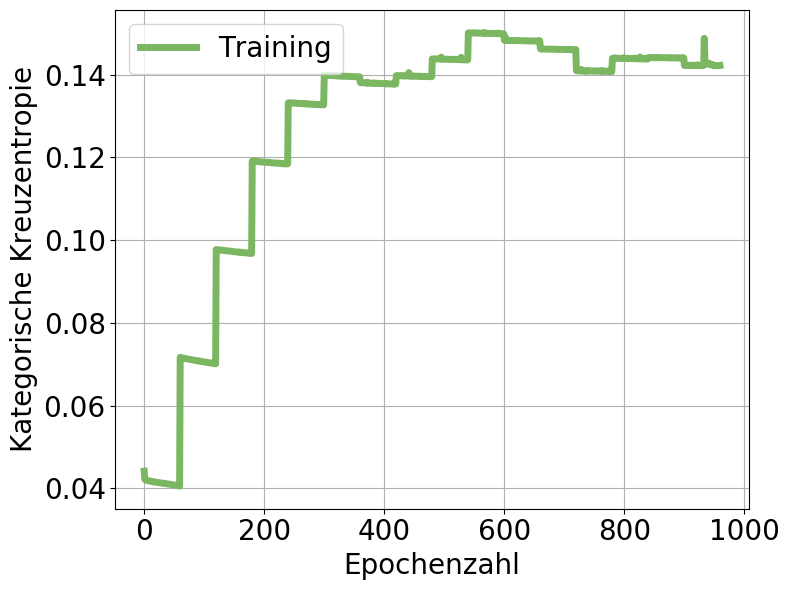

In [26]:
fig, ax = plt.subplots(1,1,figsize=(8,6), dpi=100)
ax.plot(np.arange(Nep*Nit), loss, label='Training', linewidth=5, color='#7bb661')

ax.set_ylabel('Kategorische Kreuzentropie', fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_xlabel('Epochenzahl', fontsize=20)
#ax.set_xticks(np.arange(0,Nep+1,10))
plt.setp(ax.get_xticklabels(), fontsize=20)

plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()


plt.savefig(f'bootstrap_results/one_model_{ONE_MODEL}/plots/loss.pdf', dpi=300)

plt.show()

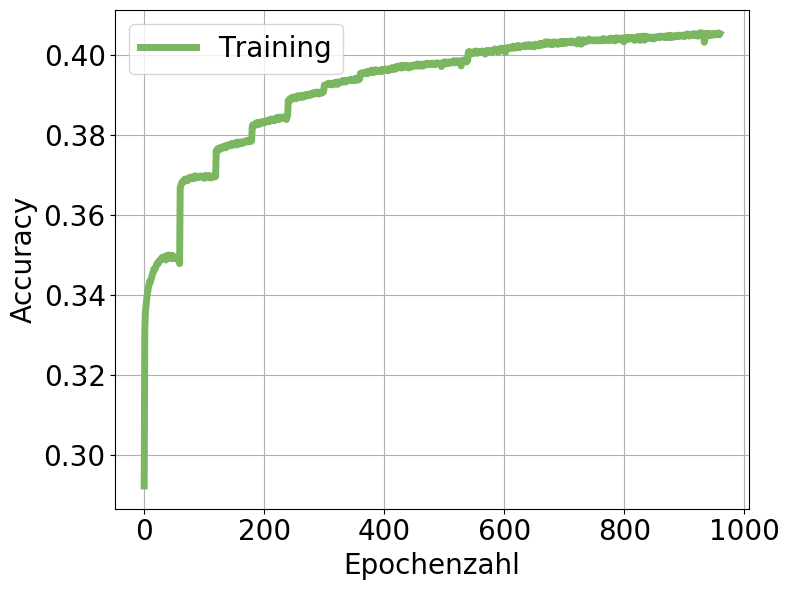

In [27]:
fig, ax = plt.subplots(1,1,figsize=(8,6), dpi=100)
ax.plot(acc, label='Training', linewidth=5, color='#7bb661')

ax.set_ylabel('Accuracy', fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_xlabel('Epochenzahl', fontsize=20)
#ax.set_xticks(np.arange(0,Nep+1,10))
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig(f'bootstrap_results/one_model_{ONE_MODEL}/plots/acc.pdf', dpi=300)


plt.show()

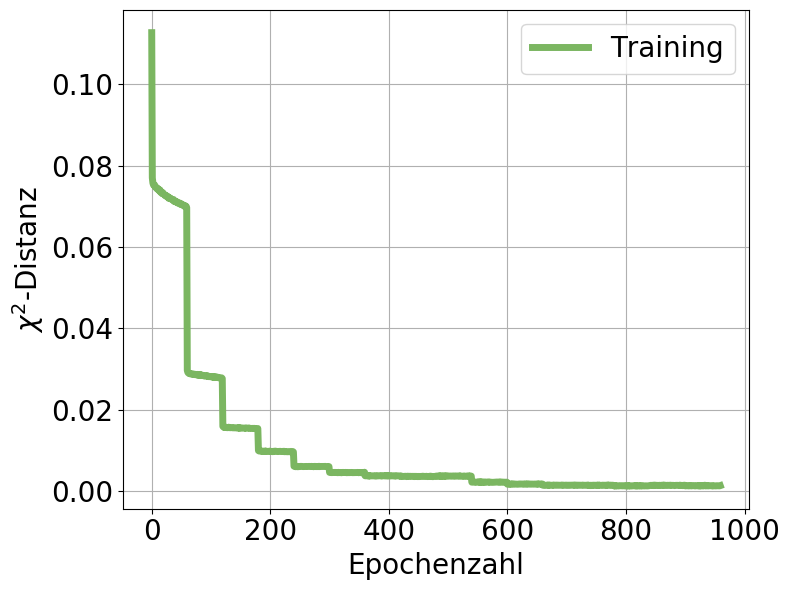

In [28]:
fig, ax = plt.subplots(1,1,figsize=(8,6), dpi=100)
ax.plot(chi, label='Training', linewidth=5, color='#7bb661')

ax.set_ylabel(r'$\chi^2$-Distanz', fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
ax.set_xlabel('Epochenzahl', fontsize=20)
#ax.set_xticks(np.arange(0,Nep+1,10))
plt.setp(ax.get_xticklabels(), fontsize=20)

plt.legend(fontsize=20)
plt.grid()
plt.tight_layout()
plt.savefig(f'bootstrap_results/one_model_{ONE_MODEL}/plots/chi.pdf', dpi=300)

plt.show()

# Evaluation with Bootstrap

In [29]:
# need one hot encoded vector for softmax
y_train_hot = np.zeros((y_train.size, y_train.max()+1))
y_train_hot[np.arange(y_train.size),y_train] = 1

y_eval_hot = np.zeros((y_eval.size, y_eval.max()+1))
y_eval_hot[np.arange(y_eval.size),y_eval] = 1

In [30]:
if not APPLY_BOOTS:
    df_bootstrap = pd.read_csv(f'bootstrap_results/one_model_{ONE_MODEL}/{NUM_BINS}bins_{Nit}it_{Nep}ep_{SAMPLE_SIZE_EVAL}samples_{NPULLS}pulls.csv')
    bootstrap_dsea = df_bootstrap.to_numpy()
    print('Read in bootstrap results.')
else:
    bootstrap_dsea = np.ndarray(shape=(NPULLS,NUM_BINS),dtype=float)
    for i in range(NPULLS):
        if (i+1)%10 ==0:
            print(i+1,' of ', NPULLS)

        # create random subsample of the evaluation data
        X_eval_bst, y_hot = utils.resample(X_eval, y_eval_hot, replace=True, n_samples=SAMPLE_SIZE_EVAL, random_state=i)# bootstrap random sample from X_test

        # predict subsample
        y_pred_temp = model.predict(X_eval_bst)

        # save f_pred for each evaluation subsample
        bootstrap_dsea[i,:] = y_pred_temp.sum(axis=0)
    
    df_boots = pd.DataFrame(bootstrap_dsea)
  
    df_boots.to_csv(f'bootstrap_results/one_model_{ONE_MODEL}/{NUM_BINS}bins_{Nit}it_{Nep}ep_{SAMPLE_SIZE_EVAL}samples_{NPULLS}pulls.csv', index=False)
    print(f'Bootstrap results saved: /bootstrap_results/one_model_{ONE_MODEL}/{NUM_BINS}bins_{Nit}it_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.csv')

Read in bootstrap results.


fig, axs = plt.subplots(5,2, figsize=(16,18))
for i in range(5):
    for j in range(2):
        sns.distplot(bootstrap_dsea[:,2*i+j], ax=axs[i,j], bins=10, kde=True, norm_hist=True)
        axs[i,j].set_xlabel('Number of events')
        axs[i,j].set_ylabel('density')

        axs[i,j].set_title(f'Energy Class: {2*i+j}')

plt.tight_layout()
plt.savefig(f'bootstrap_results/one_model_{ONE_MODEL}/plots/class_dist_{NUM_BINS}bins_{Nit}it_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.pdf', dpi=300)
plt.savefig(f'bootstrap_results/one_model_{ONE_MODEL}/plots/class_dist_{NUM_BINS}bins_{Nit}it_{Nep}ep_{SAMPLE_SIZE}samples_{NPULLS}pulls.png', dpi=300)

plt.show()

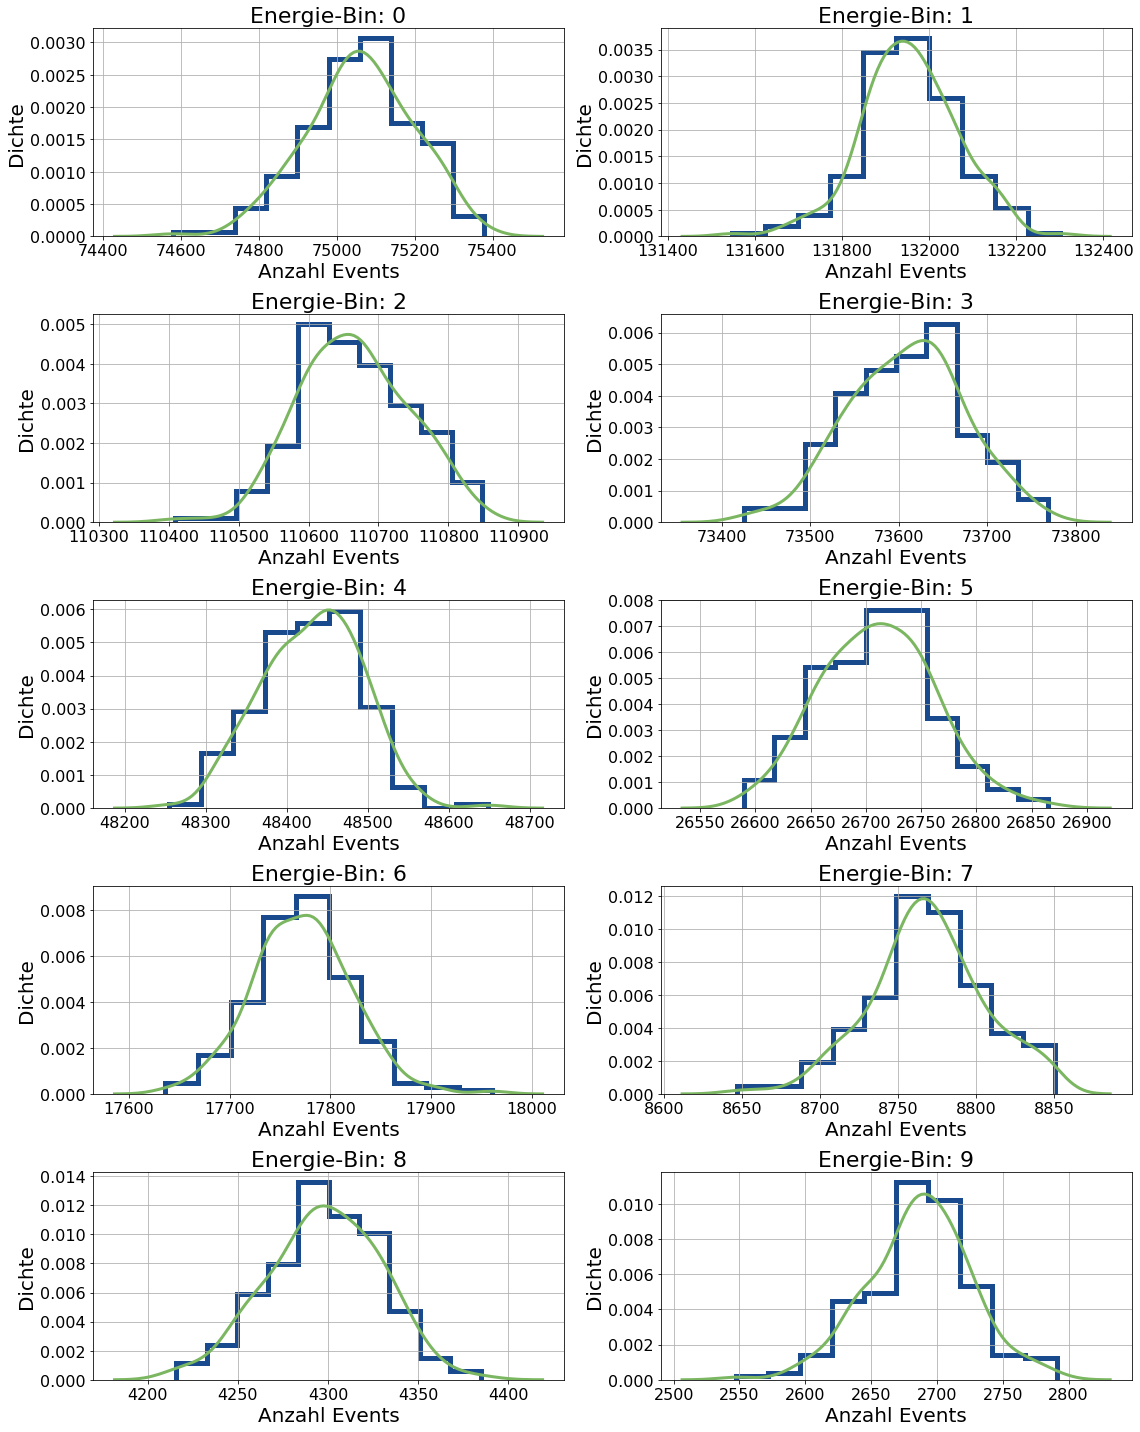

In [31]:
fig, axs = plt.subplots(5,2, figsize=(16,20))
for i in range(5):
    for j in range(2):
        sns.distplot(bootstrap_dsea[:,2*i+j], ax=axs[i,j], bins=10, kde=True, norm_hist=True, kde_kws={'linewidth': 3, 'color': '#7bb661'}, hist_kws={'color': '#194a8d', 'histtype': 'step', 'linewidth': 5, 'alpha': 1})
        axs[i,j].set_xlabel('Anzahl Events', fontsize=20)#df1c44
        axs[i,j].set_ylabel('Dichte', fontsize=20)
        axs[i,j].set_title(f'Energie-Bin: {2*i+j}', fontsize=22)
        plt.setp(axs[i,j].get_xticklabels(), fontsize=16)
        plt.setp(axs[i,j].get_yticklabels(), fontsize=16)
        axs[i,j].grid()

plt.tight_layout()
plt.savefig(f'bootstrap_results/one_model_{ONE_MODEL}/plots/class_dist_{NUM_BINS}bins_{Nit}it_{Nep}ep_{SAMPLE_SIZE_EVAL}samples_{NPULLS}pulls.pdf', dpi=300)
plt.show()

In [32]:
boots_mean = bootstrap_dsea.mean(axis=0)
boots_mean_norm = boots_mean/boots_mean.sum()
boots_mean_norm

array([0.15013361, 0.26393141, 0.22135055, 0.14723043, 0.09687145,
       0.05342576, 0.03554693, 0.01753967, 0.0085966 , 0.00537359])

In [33]:
boots_std = bootstrap_dsea.std(axis=0)
boots_std_norm = boots_std/boots_mean.sum()
boots_std_norm

array([2.73824184e-04, 2.21727689e-04, 1.55844372e-04, 1.30016082e-04,
       1.21865229e-04, 1.01619915e-04, 9.86705238e-05, 7.41741023e-05,
       6.23756351e-05, 7.85324921e-05])

In [34]:
boots_median = np.median(bootstrap_dsea, axis=0)
boots_median_norm = boots_median/boots_median.sum()
boots_median_norm

array([0.15013718, 0.26392324, 0.22133749, 0.14723414, 0.09688416,
       0.05342457, 0.03554867, 0.01753762, 0.00859671, 0.00537622])

In [35]:
quantile_16 = np.quantile(bootstrap_dsea, 0.16, axis=0)
quantile_16_norm = quantile_16/boots_median.sum()
quantile_16_norm

array([0.14984979, 0.26374511, 0.22120021, 0.1471003 , 0.09673767,
       0.0533227 , 0.03545947, 0.01746946, 0.00853444, 0.00529212])

In [36]:
quantile_84 = np.quantile(bootstrap_dsea, 0.84, axis=0)
quantile_84_norm = quantile_84/boots_median.sum()
quantile_84_norm

array([0.15041562, 0.26413942, 0.22151855, 0.14735482, 0.09698332,
       0.05351698, 0.03564084, 0.01761113, 0.00865928, 0.00544035])

In [37]:
boots_mean/boots_median

array([0.99996317, 1.00001783, 1.0000459 , 0.99996168, 0.99985569,
       1.00000904, 0.99993782, 1.00010358, 0.99997418, 0.99949822])

# True distribution

In [38]:
_, f_true = np.unique(y_eval, return_counts=True)
bins = np.logspace(np.log10(LOWER_LIMIT), np.log10(UPPER_LIMIT), NUM_BINS+1)
bin_centers = np.array([(bins[i] + (bins[i+1]-bins[i])/2) for i in range(NUM_BINS)])
bin_width = np.array([bins[i+1]-bins[i] for i in range(NUM_BINS)])
f_true = f_true/len(y_eval)
f_true

array([0.146518, 0.24642 , 0.223364, 0.159558, 0.099718, 0.05844 ,
       0.032956, 0.018036, 0.009848, 0.005142])

# Visualization of the spectrum

In [39]:
f_dsea = boots_median_norm

In [40]:
f_err = np.stack([f_dsea-quantile_16_norm, quantile_84_norm-f_dsea])
f_err

array([[2.87388862e-04, 1.78133241e-04, 1.37280517e-04, 1.33834636e-04,
        1.46492451e-04, 1.01872807e-04, 8.92005366e-05, 6.81604571e-05,
        6.22660150e-05, 8.41004993e-05],
       [2.78443197e-04, 2.16178569e-04, 1.81054396e-04, 1.20683033e-04,
        9.91539327e-05, 9.24071031e-05, 9.21707574e-05, 7.35052294e-05,
        6.25683813e-05, 6.41308314e-05]])

In [41]:
bins = np.logspace(np.log10(LOWER_LIMIT), np.log10(UPPER_LIMIT), NUM_BINS+1)
bin_centers = np.array([(bins[i] + (bins[i+1]-bins[i])/2) for i in range(NUM_BINS)])
bin_width = np.array([bins[i+1]-bins[i] for i in range(NUM_BINS)])

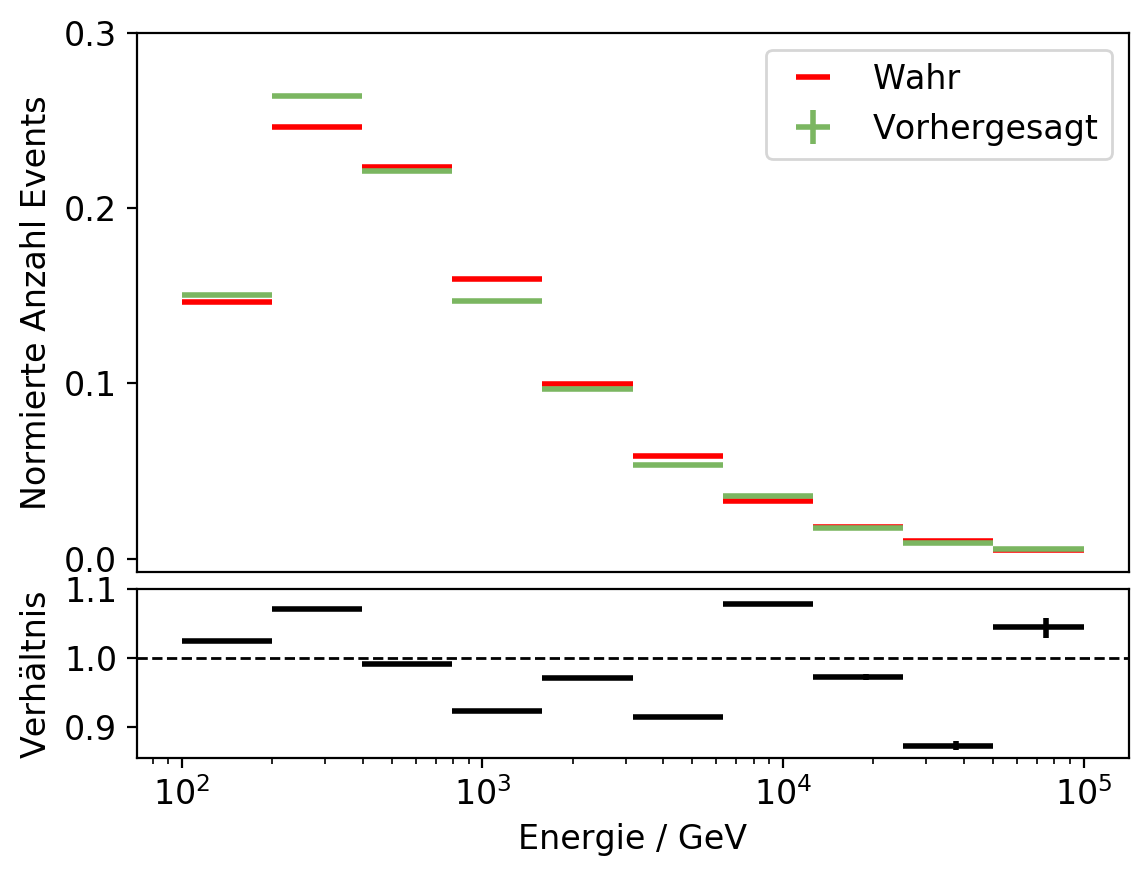

In [42]:
fig = plt.figure(figsize=(6.4,4.8),dpi=200) #dpi 300 for full hd
fig.tight_layout()

# seperation DSEA plot and ratio
gs = matplotlib.gridspec.GridSpec(4, 1)
axes1 = fig.add_subplot(gs[:-1])
axes2 = fig.add_subplot(gs[-1], sharex=axes1)
fig.subplots_adjust(hspace = .1) #0.001

# spectrum
axes1.errorbar(bin_centers, f_true, fmt=' ', color='red', xerr=bin_width/2, elinewidth=2, label='Wahr') #true distr
axes1.errorbar(bin_centers, f_dsea, fmt=' ', color='#7bb661', xerr=bin_width/2, yerr=f_err, elinewidth=2, label='Vorhergesagt') #pred. distr
axes1.set_xscale('log')
axes1.set_xticks([],[])
axes1.set_yticks([0.0, 0.1, 0.2, 0.3])
axes1.set_ylabel('Normierte Anzahl Events', fontsize=12)
plt.setp(axes1.get_xticklabels(), fontsize=12)
plt.setp(axes1.get_yticklabels(), fontsize=12)

# ratio
axes2.errorbar(bin_centers, f_dsea/f_true, fmt=' ', color='black', xerr=bin_width/2, yerr=f_err/f_true, elinewidth=2)
axes2.axhline(1, color='k', linestyle='--', linewidth=1)
axes2.set_xscale('log')
axes2.set_xlabel(r'Energie / GeV', fontsize=12)
axes2.set_yticks([0.9,1.0,1.1])
axes2.set_ylabel('Verhältnis', fontsize=12)
plt.setp(axes2.get_xticklabels(), fontsize=12)
plt.setp(axes2.get_yticklabels(), fontsize=12)

# disable xticks in top plot
axes1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axes1.legend(fontsize=12)


plt.savefig(f'bootstrap_results/one_model_{ONE_MODEL}/plots/spectrum_dist_{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE_EVAL}samples_{NPULLS}pulls.pdf', dpi=300)

plt.show()

# Predict single events

In [43]:
y_pred = model.predict(X_eval)

In [44]:
np.where(y_eval==8)

(array([   332,    391,    625, ..., 499830, 499924, 499937]),)

In [45]:
# index/rows of the single predictions
ind_i = 245
ind_f = 251

y_single_pred = y_pred[ind_i:ind_f]
y_single_true = y_eval[ind_i:ind_f]
y_single_true.shape

(6,)

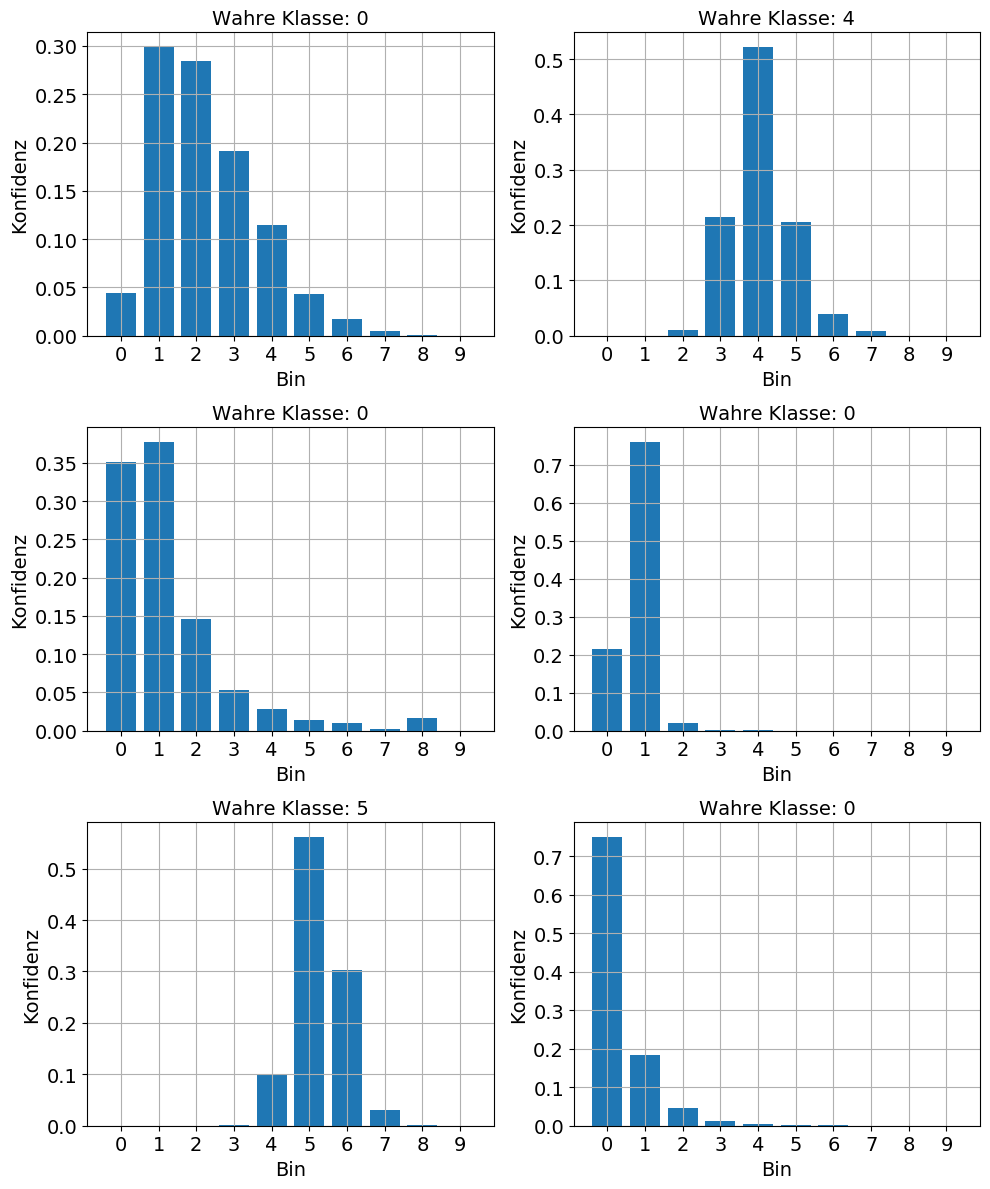

In [46]:
fig, axs = plt.subplots(3, 2, figsize=(10,12), dpi=100)
for i in range(3):
    for j in range(2):
        #axs[i,j].hist(np.arange(NUM_BINS)-bin_width/2, rwidth=bin_width, weights=y_single_pred[i+j], histtype='step')
        axs[i,j].bar(np.arange(NUM_BINS), y_single_pred[2*i+j])
        
        axs[i,j].set_title(f'Wahre Klasse: {y_single_true[2*i+j]}', fontsize=14)
        axs[i,j].set_xlabel('Bin', fontsize=14)
        axs[i,j].set_ylabel('Konfidenz', fontsize=14)
        axs[i,j].set_xticks(np.arange(NUM_BINS))
        axs[i,j].grid()
        plt.setp(axs[i,j].get_xticklabels(), fontsize=14)
        plt.setp(axs[i,j].get_yticklabels(), fontsize=14)

plt.tight_layout()
plt.savefig(f'bootstrap_results/one_model_{ONE_MODEL}/plots/SingleEvents_{NUM_BINS}bins_{Nep}ep_{SAMPLE_SIZE_EVAL}samples_{NPULLS}pulls.pdf', dpi=300)

#plt.savefig('output/single_events.pdf', dpi=300)
#plt.savefig('output/single_events.png', dpi=300)

plt.show()

# Correlation matrix 

In [47]:
y_pred_cls = np.argmax(y_pred, axis=1)

In [48]:
df_results = pd.DataFrame(data=y_pred)
matrix = df_results.corr()

In [49]:
mask = np.triu(np.ones_like(matrix, dtype=bool))

In [50]:
# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=15, center="light", as_cmap=True)

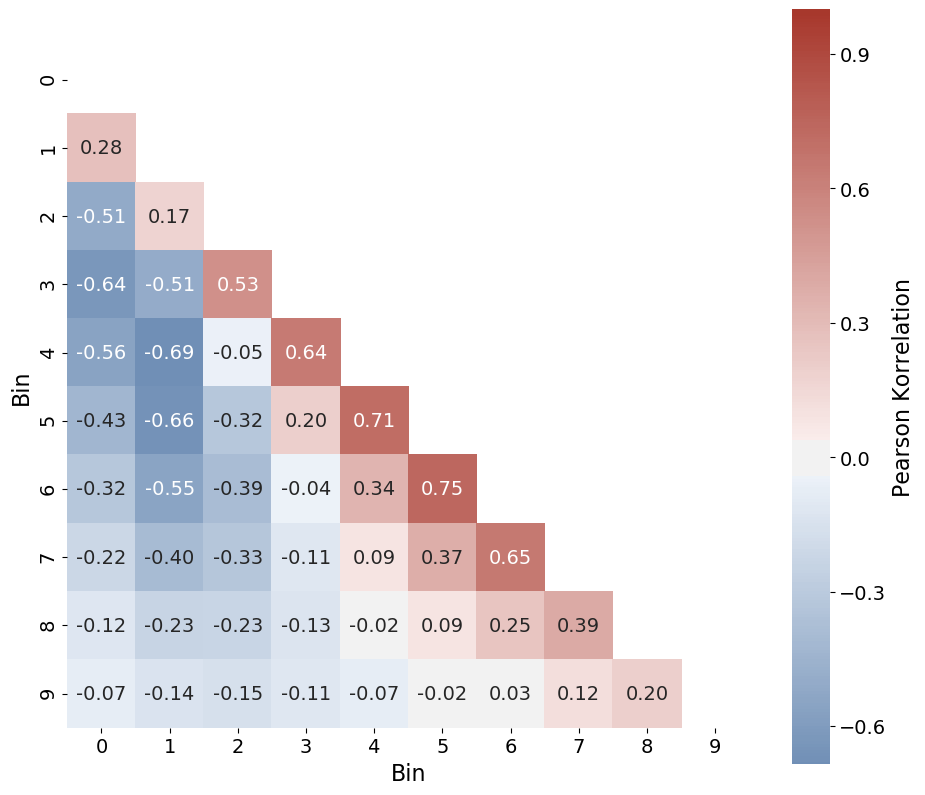

In [51]:
plt.figure(figsize=(11,10), dpi=100)
ax = sns.heatmap(matrix, mask=mask, annot=True, fmt='.2f', center=0, square=True, cmap=cmap, annot_kws={"fontsize":14}) #'coolwarm'

plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#plt.title('Correlation matrix')
plt.xlabel('Bin', fontsize=16)
plt.ylabel('Bin', fontsize=16)
#colorbar config
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Pearson Korrelation', fontsize=16)

plt.savefig(f'bootstrap_results/one_model_{ONE_MODEL}/plots/correlation_matrix.pdf', dpi=300)
plt.show()

# Metrics

In [52]:
chi2 = 0.5 * np.sum((f_dsea-f_true)**2 / (f_dsea+f_true))
chi2

0.0008048347967304725

In [53]:
y_pred_cls = np.argmax(y_pred, axis=1)

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
print('Evaluation on Evaluation data:\r')
print('Accuracy: %.4f' % accuracy_score(y_eval, y_pred_cls))
print("Precision: %.4f" % precision_score(y_eval, y_pred_cls, average='weighted'))
print("Recall: %.4f" % recall_score(y_eval, y_pred_cls, average='weighted'))
print(classification_report(y_eval, y_pred_cls))

Evaluation on Evaluation data:
Accuracy: 0.3749
Precision: 0.3605
Recall: 0.3749
              precision    recall  f1-score   support

           0       0.51      0.55      0.53     73259
           1       0.38      0.64      0.47    123210
           2       0.34      0.36      0.35    111682
           3       0.34      0.16      0.21     79779
           4       0.30      0.15      0.20     49859
           5       0.30      0.11      0.16     29220
           6       0.27      0.15      0.19     16478
           7       0.28      0.10      0.14      9018
           8       0.25      0.13      0.17      4924
           9       0.16      0.18      0.17      2571

    accuracy                           0.37    500000
   macro avg       0.31      0.25      0.26    500000
weighted avg       0.36      0.37      0.35    500000



In [55]:
from sklearn.metrics import jaccard_score
#'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
#'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account

jaccard_score = jaccard_score(y_eval, y_pred_cls, average='micro')
print('Jaccard-Score: %.4f' % jaccard_score)

Jaccard-Score: 0.2307
